# Implementing the BCa Bootstrapping in Python

The [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a powerful tool for carrying out inference on statistics whose distribution is unknown. The non-parametric version of the bootstrap obtains variation around the point estimate of a statistic by randomly resampling the data with replacement and recalculating the bootstrap-statistic based on these resamples. This simulated distribution can be used to obtain (close-to) valid frequentist inference measures like p-values and confidence intervals (CIs). This post will show how to implement the bias-corrected and accelerated ([BCa](https://www.tandfonline.com/doi/abs/10.1080/01621459.1987.10478410)) bootstrap to calculate either one and two-sided CIs. A good discussion of bootstrapped p-values can be found [here](http://qed.econ.queensu.ca/working_papers/papers/qed_wp_1127.pdf). Nathaniel Helwig's excellent class [notes](http://users.stat.umn.edu/~helwig/notes/bootci-Notes.pdf) are used or paraphrased throughout this post.

If you are want to use an existing `python` package, [`arch`](https://arch.readthedocs.io/en/latest) is an excellent choice (I have made use of it in other [posts](http://www.erikdrysdale.com/threshold_and_power)). There are two advantages for implementing a custom procedure. First, `arch` is limited to a number of sampling strategies, and I recently found myself needing to implement a stratified bootstrap, which I could not do with the package. Second, the `conf_int` method only allows inference for a specific level (i.e. type-I error rate) for every sampling run. If you are carrying out statistical simulations this is a huge waste since computing the 90% or 95% CI can be done from the same bootstrap simulation. Lastly this blueprint can modified for other uses.

The motivating example for this post will be to estimate the threshold for determining the positive predictive value ([PPV](https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values)) of a classifier. This statistic is a good target for the BCa bootstrap because its distribution is skewed, biased, and non-normal. Anyone developing machine learning tools for the real world will understand the importance of [this task](http://www.erikdrysdale.com/threshold_and_power/), since researchers want to ensure their algorithms obtain *at least* some level of performance in a generalized setting. For simplicity the scores of the algorithm will come from a normal distribution to allow for an easy comparison to the "ground truth".  

# (1) Background

To begin I'll establish the notation that will be used through the rest of the post. Define the statistic of interest as $\theta = s(X)$, where $X_i \sim F$ from IID draws. The statistic $s$ can be anything like the mean, median, skew, PPV, etc. Of course, if we knew the cdf $F$, one could simply sample from it and estimate $\theta$ by appealing to the law of large numbers. However researchers almost never know the distribution the data comes from, and if they do, the exact parameters of the distribution are unknown. Instead we can use an empirical draw of the data: $\hat{X} = (X_1, \dots, X_n)$ to approximate the actual CDF: $\hat{F}(\hat{X} \leq x) \approx F(X \leq x)$. From the [Glivenko-Cantelli theorem](https://en.wikipedia.org/wiki/Glivenko%E2%80%93Cantelli_theorem) we know that as $n \to \infty$, the empirical CDF (ECDF) approaches the true CDF.

Using the ECDF from a given draw of data as an estimate of $F$, means using the CDF of a discrete random variable. This non-parametric approximation naturally creates some estimation error, but for a reasonably sized $n$ it will be small. When  bootstrapping is referred to "sampling with replacement", it is actually referring to sampling from the ECDF. Since this is a discrete distribution it means that some values can be sampled more than once. Draws for the ECDF, or bootstrapped samples, will be denoted as follows:

$$
\begin{align*}
\hat\theta &= s(X) \\
X_1^*, \dots, X_n^* &\sim \hat{F}  \\
\hat\theta^* &= s(X^*)
\end{align*}
$$

The PPV is the ratio of the true positive rate (TPR) to the predicted positive rate (which includes the false positive rate (FPR)), weighted by the prevalence of the binary outcome: $\mu_y = E[y==1]$. In this post we will assume that the scores of the classifier come from a normal distribution: $x|y=i \sim N(\mu_i,\sigma_i^2)$, for $i=[1,2]$. The distribution for the ground-truth PPV will be smooth and monotonically increasing over $t$ since $\mu_y$ is fixed, as defined by \eqref{eq:PPV_true}. However, its empirical estimate will necessarily by discontinuous, and not even necessarily monotonic! This is because the count of the number of TPs and FPs is used rather than the theoretical CDF and prevalence. Note that $\Phi$ refers to the standard normal CDF.

$$
\begin{align*}
\text{PPV}_\Phi(t) &= \frac{\Phi_1(t)\cdot\mu_y}{\Phi_1\cdot\mu_y + \Phi_0\cdot(1-\mu_y)} \label{eq:PPV_true} \\
\Phi_1(t) &= \Phi([\mu_1 - t]/\sigma_1), \hspace{3mm} \Phi_0(t) = \Phi([\mu_0 - t]/\sigma_0) \\
\hat{\text{PPV}}(t) &= \frac{NTP(t)}{NTP(t) + NFP(t)} \\
NTP(t) &= \sum_{i: y_i =1} y_i \geq t, \hspace{3mm} NFP(t) = \sum_{i: y_i =0} y_i \geq t
\end{align*}
$$

The codeblock below loads in the necessary modules and shows that the theoretical PPV aligns with the average empirical PPV across different thresholds ($t$).

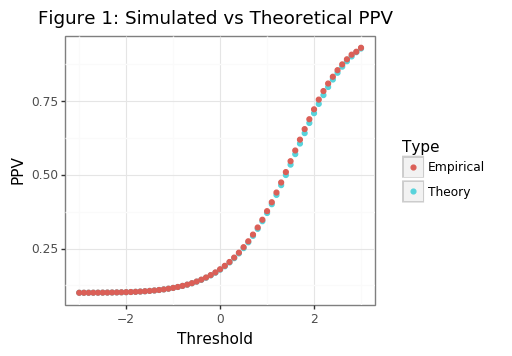

<ggplot: (8766715431621)>


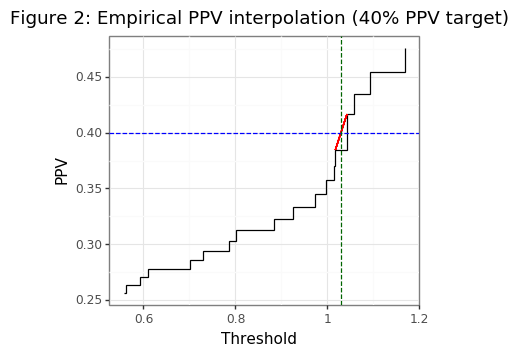

<ggplot: (8766715866737)>


In [20]:
import os
from time import time
import pandas as pd
import numpy as np
from sklearn.utils import resample
from numpy.random import randn
from scipy.stats import norm, t
import plotnine
from plotnine import *
from scipy.optimize import minimize_scalar
from scipy import stats
# !pip install git+https://github.com/retostauffer/python-colorspace 
from colorspace.colorlib import HCL

def gg_color_hue(n):    
    hues = np.linspace(15, 375, num=n + 1)[:n]
    hcl = []
    for h in hues:
        hcl.append(HCL(H=h, L=65, C=100).colors()[0])
    return hcl

def dgp(n0, n1, mu):
    """
    FUNCTION TO CREATE BINARY RISK SCORES
    """
    y = np.append(np.repeat(0, n0), np.repeat(1, n1))
    score = np.append(randn(n0), randn(n1) + mu)
    return y, score

def PPV_theory(thresh, mu0, mu1, prev):
    """
    FUNCTION TO RETURN ASYMPTOTIC PPV FOR NORMALLY DISTRIBUTED SCORES
    """
    tpr = norm.cdf(mu1 - thresh)
    fpr = norm.cdf(mu0 - thresh)
    ppv = tpr*prev / (tpr*prev + fpr*(1-prev))
    return ppv

def PPV_fun(y, score, thresh):
    """
    FUNCTION TO CALCULATE EMPIRICAL PPV VALUE FOR A GIVEN THRESHOLD
    """
    ntp = np.sum(score[y == 1] >= thresh)
    nfp = np.sum(score[y == 0] >= thresh)
    if ntp == nfp == 0:
        return np.NaN
    else:
        ppv = ntp / (ntp + nfp)
    return ppv

thresh_seq = np.round(np.arange(-3,3.1,0.1),2)
theory_seq = np.array([PPV_theory(tt, mu0=0, mu1=2, prev=0.1) for tt in thresh_seq])

mu0 = 0
mu1 = 2
n0, n1 = 90, 10
prev = n1 / (n1 + n0)

np.random.seed(1234)
nsim = 5000

mat = np.zeros([nsim, len(thresh_seq)])
for ii in range(nsim):
    y, score = dgp(n0=n0, n1=n1, mu=mu1)
    mat[ii] = [PPV_fun(y, score, tt) for tt in thresh_seq]
    
df_sim = pd.DataFrame({'thresh':thresh_seq, 'theory':theory_seq, 'emp':np.nanmean(mat,0)}).melt('thresh',None,'tt')

plotnine.options.figure_size = (4.5, 3.5)
gg_theory = (ggplot(df_sim, aes(x='thresh', y='value', color='tt')) + theme_bw() + 
            geom_point() + labs(x='Threshold', y='PPV') + 
            ggtitle('Figure 1: Simulated vs Theoretical PPV') + 
            scale_color_discrete(name='Type',labels=['Empirical','Theory']))
print(gg_theory)

np.random.seed(102)
y, score = dgp(n0=n0, n1=n1, mu=mu1)
thresh_seq = np.sort(np.unique(score))
df_ex = pd.DataFrame({'ppv':[PPV_fun(y, score, tt) for tt in thresh_seq],'thresh':thresh_seq})
yy, xx = tuple(df_ex.query('ppv<0.4').tail(1).values.flatten())
yend, xend = tuple(df_ex.query('ppv>0.4').head(1).values.flatten())
xstar = (0.4-yy)/((yend - yy)/(xend - xx))+xx

plotnine.options.figure_size = (4.5,3.5)
gg_ppv_ex = (ggplot(df_ex.query('thresh>0.5 & thresh<1.5 & ppv>0.25 & ppv<0.5 & ppv!=0.4'),aes(x='thresh',y='ppv')) + 
             theme_bw() + geom_step() + 
            labs(x='Threshold', y='PPV') + 
            ggtitle('Figure 2: Empirical PPV interpolation') + 
            geom_segment(x=xx,xend=xend,y=yy,yend=yend,color='red') + 
            geom_hline(yintercept=0.4,color='blue',linetype='--') + 
            geom_vline(xintercept=xstar,color='darkgreen',linetype='--'))
print(gg_ppv_ex)

Though the asymptotic PPV curve is smooth (see Figure 1), the empirical PPV has is non-smooth (as Figure 2 shows). Our statistic of interest will be the value of the threshold that is needed to meet a targeted PPV. For the PPV curve, this amounts to the following:

$$
\begin{align*}
t^*(p) &= \Big\{\inf_t : PPV(t)=p  \Big\} \label{eq:tstar}
\end{align*}
$$

Note that we want \eqref{eq:tstar} to find the infimum of thresholds since if there are two distinct thresholds that obtain the same PPV, the smaller one will have a higher senitivity. For the empirical curve, the threshold will need to be interpolated when the targeted value cannot be found. For example, if the targeted PPV is 0.5, but the closest values we can find are PPVs of 0.49 and 0.54, for threshold values of 1 and 2, respectively, then a linear interpolation will estimate a threshold of 1.2. In the case where the targeted PPV is larger than the largest empirical PPV, an interpolation will also be used. However it is not advised to pick PPVs that are generally beyond the range of the classifier because these estimates will be noisy.

The `thresh_ppv` function below also has a built-it [Jackknife](https://en.wikipedia.org/wiki/Jackknife_resampling) estimate of the statistic, since these will be required later. The Jackknife calculates the statistic by leaving one sample value, so there are $n$ estimates of it. Because the empirical PPV is discrete, deleting an observation whose value is below a given threshold will not affect the PPV and hence the choice of threshold. Deleting a positive label observation whose score is at or above the threshold will necessarily lower the PPV, and so we can interpolate the new slope/intercept position to obtain the original PPV. Similarly, deleting a negative observation will make whatever the the next smallest threshold is to the current one the optimal choice.[[^1]] It is exceedingly quick therefore to approximate the leave-one-observation out statistic for the PPV. 

Note the `draw_samp` function, which draws data with replacement, can make use of the `strafify` argument. Normally one would want to make use of the variation in the label prevalence, however, since this post is inspired by a validation trial for a machine learning algorithm, it is likely that the label balance is already known with a high degree of confidence. Lastly, because there can be discontinuities in the data, the `thresh_ppv` function will always try to find the infimum of values, because we know on a statistical level the relationship should be monotonic (for reasonable assumptions about the distribution of $\Phi_0$ and $\Phi_1$.

In [5]:
def draw_samp(*args, strata=None):
    """
    FUNCTION DRAWS DATA WITH REPLACEMENT (WITH STRATIFICATION IF DESIRED)
    """
    args = list(args)
    if strata is not None:
        out = resample(*args, stratify=strata)
    else:
        out = resample(*args)
    if len(args) == 1:
        out = [out]
    return out
        
def thresh_interp(df, target):
    """
    LINEARLY INTERPOLATES PPV TO FIND THRESHOLD
    """
    idx = df.ppv.isnull()
    if idx.sum() > 0:
        df = df[~idx]
    df = df.assign(err=lambda x: x.ppv - target).assign(err1 = lambda x: x.err.shift(1))
    if df.ppv.max() < target:
        df = df.query('ppv == ppv.max()').sort_values('thresh1').head(1)
    else:
        df = df[((np.sign(df.err1)==-1) & (np.sign(df.err)==1)) | ((np.sign(df.err1)==-1) & (np.sign(df.err)==0))]
        df = df.sort_values('thresh1').head(1)
    thresh0, thresh1 = df.thresh1.values[0], df.thresh.values[0]
    ppv0, ppv1 = df.ppv1.values[0], df.ppv.values[0]
    slope = (ppv1 - ppv0) / (thresh1 - thresh0)
    tt = thresh1 - (ppv1 - target)/slope
    return tt

def thresh_PPV(*args, **kwargs):
    """
    FUNCTION TO FIND THE THRESHOLD THAT CORRESPONDS TO A TARGET PPV
    First two *args should be y and score. target (PPV) should be in **kwargs
    Other optional **kwargs include: jackknife (whether to use jackknife), ret_df (whether to return data_frame)
    """
    # --- assign --- #
    jackknife = False
    ret_df = False
    if 'jackknife' in kwargs:
        jackknife = kwargs['jackknife']
    if 'ret_df' in kwargs:
        ret_df = kwargs['ret_df']
    assert 'target' in kwargs
    target = kwargs['target']
    assert len(args) == 2
    y, score = args[0], args[1]
    assert len(y) == len(score)
    assert np.all((y==0) | (y==1))
    # --- calculate --- #
    s0, s1 = score[y == 0], score[y == 1]
    u_scores = np.sort(score)  # Useful for step function
    store = np.zeros([len(u_scores),2],int)
    for ii, tt in enumerate(u_scores):
        store[ii] = [np.sum(s0 >= tt), np.sum(s1 >= tt)]
    dat = pd.DataFrame(store,columns=['n0','n1']).assign(thresh=u_scores,tot=store.sum(1))
    dat = dat.assign(thresh1=lambda x: x.thresh.shift(1), ppv=lambda x: x.n1/(x.tot))
    dat = dat.assign(ppv1=lambda x: x.ppv.shift(1), tot1=lambda x: x.tot.shift(1)).iloc[1:]
    if ret_df:
        return dat
    tstar = thresh_interp(dat, target)
    # Do a fast interpolation with the Jackknife
    # Remember: all s[1]<t and s[0]<t do not impact calculation (i.e. False negatives and True Negatives)
    if jackknife:
        tmp = dat.query('thresh>=@tstar & thresh1<@tstar')
        n0, n1, tot0, tot1 = tmp.n0.values[0], tmp.n1.values[0], tmp.tot1.values[0], tmp.tot.values[0]
        thresh0, thresh1 = tmp.thresh1.values[0], tmp.thresh.values[0]
        ppv0, ppv1 = tmp.ppv1.values[0], tmp.ppv.values[0]
        holder = []
        holder.append(np.repeat(tstar,len(score) - tot1)) # Removing all false/true negatives
        # Slope for removing TP
        ppv1_new, ppv0_new = (n1-1)/tot1, (n1-1)/tot0
        slope_new = (ppv1_new - ppv0_new) / (thresh1 - thresh0)
        assert ppv1_new < ppv1  # Has to decrease
        holder.append(np.repeat(thresh1 + (ppv1 - ppv1_new)/slope_new, n1))
        # Note that becasue n1/(tot0-1) = n1/tot1, implies thresh0 will be be the new choice
        holder.append(np.repeat(thresh0, n0))
        tstar = np.concatenate(holder)
        tstar = tstar[np.abs(tstar)!=np.Inf]
    return tstar

The simulation below will show the distribution of thresholds that are found for PPV targets of 25%, 50% and 75% when the scores and labels are generated from the true data generating process (DGP). An example of the distribution generated by the bootstrap will also be made. 

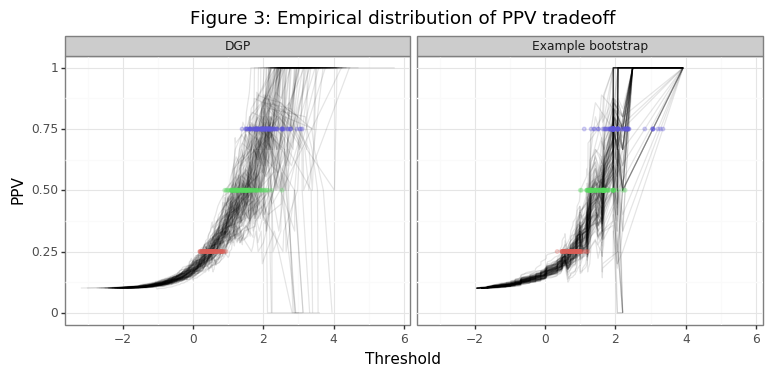

<ggplot: (8766757080797)>


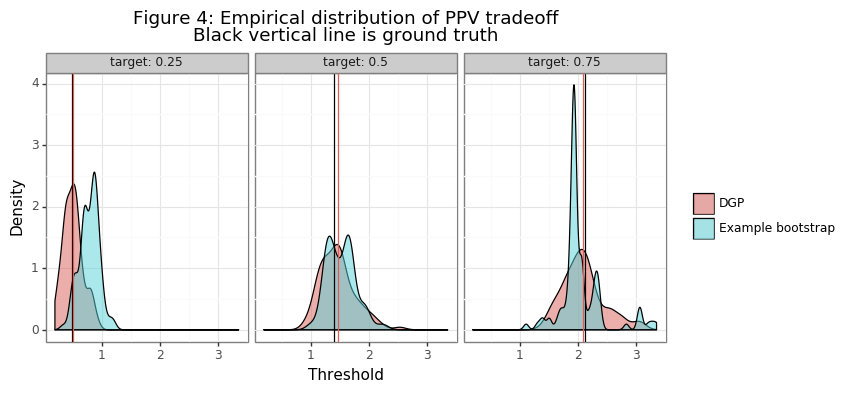

<ggplot: (8766756878801)>


In [6]:
# Visualize a threshold/PPV curve
np.random.seed(1)
target_ppv = 0.5
nsim = 100
holder = []
for ii in range(nsim):
    y, score = dgp(n0=n0, n1=n1, mu=mu1)
    # Get threshold for different PPV scores
    t25 = thresh_PPV(y, score, target=target_ppv/2)
    t50 = thresh_PPV(y, score, target=target_ppv*1)
    t75 = thresh_PPV(y, score, target=target_ppv*1.5)
    tmp = thresh_PPV(y, score, target=target_ppv, ret_df=True)
    tmp = tmp[['thresh','ppv']].assign(sim=ii,t25=t25,t50=t50,t75=t75)
    holder.append(tmp)
dat = pd.concat(holder).reset_index(None,True)
dat2 = dat.groupby('sim')[['t25','t50','t75']].min().reset_index().melt('sim',None,'target')
dat2 = dat2.assign(target=lambda x: x.target.str.replace('t','').astype(float)/100)

# Repeat visualization for bootstrap
holder_bs = []
for ii in range(nsim):
    ytil, stil = draw_samp(y, score, strata=y)
    # Get threshold for different PPV scores
    t25 = thresh_PPV(ytil, stil, target=target_ppv/2)
    t50 = thresh_PPV(ytil, stil, target=target_ppv*1)
    t75 = thresh_PPV(ytil, stil, target=target_ppv*1.5)
    tmp = thresh_PPV(ytil, stil, target=target_ppv, ret_df=True)
    tmp = tmp[['thresh','ppv']].assign(sim=ii,t25=t25,t50=t50,t75=t75)
    holder_bs.append(tmp)
dat_bs = pd.concat(holder_bs).reset_index(None,True)
dat2_bs = dat_bs.groupby('sim')[['t25','t50','t75']].min().reset_index().melt('sim',None,'target')
dat2_bs = dat2_bs.assign(target=lambda x: x.target.str.replace('t','').astype(float)/100)
dat_both = pd.concat([dat.assign(tt='DGP'), dat_bs.assign(tt='Example bootstrap')])
dat2_both = pd.concat([dat2.assign(tt='DGP'), dat2_bs.assign(tt='Example bootstrap')])

plotnine.options.figure_size = (9,3.5)
gg_ex = (ggplot(dat_both, aes(x='thresh',y='ppv',group='sim')) + theme_bw() + 
         geom_line(alpha=0.1) + facet_wrap('~tt') + 
         geom_point(aes(x='value',y='target',color='target.astype(str)'),
                    size=1,alpha=0.25,data=dat2_both, inherit_aes=False) + 
         ggtitle('Figure 3: Empirical distribution of PPV tradeoff') + 
         guides(color=False) + labs(y='PPV',x='Threshold'))
print(gg_ex)

target_seq = [0.25, 0.5, 0.75]
thresh_seq = [minimize_scalar(fun=lambda x: (PPV_theory(x, 0, 2, 0.1)-pp)**2).x for pp in target_seq]
tmp = pd.DataFrame({'thresh':thresh_seq, 'target':target_seq})
tmp2 = dat2_both.groupby(['tt','target']).value.mean().reset_index().query('tt=="DGP"')
title = 'Figure 4: Empirical distribution of PPV tradeoff\nBlack vertical line is ground truth'
plotnine.options.figure_size = (8,3.5)
gg_bs = (ggplot(dat2_both,aes(x='value',fill='tt')) + theme_bw() + guides(color=False) + 
         facet_wrap('~target',labeller=label_both,nrow=1) + geom_density(alpha=0.5) + 
         labs(x='Threshold',y='Density') + scale_fill_discrete(name=' ') + ggtitle(title) + 
         geom_vline(aes(xintercept='thresh'),data=tmp) + 
         geom_vline(aes(xintercept='value',color='tt'),data=tmp2))
print(gg_bs)

Figure 3 shows the range of thresholds that would be chosen by the `thresh_PPV` function for PPV different targets, along with the different realizations of the empirical PPV curves. The second figure takes the last draw of the data in the simulation and shows the variation in the threshold statistics generated in that bootstrapping instance. Unsurprisingly the latter has more variation, since the empirical PPV for this data is noisier. Figure 4 compares the distribution of a bootstrap instance with those of the point estimates from the simulation. Note these distributions are not statistically comparable, since the DGP is the true variation and the bootstrap distribution only comes from one example. The inference procedures needed to obtain statistically meaningful insights from the bootstrap distribution are be described below.

## (2) Bootstrapping approaches

The statistical quality of a bootstrap CI is determined by its coverage. For example, a two-sided confidence interval of level $1-\alpha$  has the "right" coverage when:

$$
P(\theta_l \leq \theta \leq  \theta_u) = c = 1-\alpha
$$

If $c > 1-\alpha$, then the CI is said to be conservative because it under-rejects the true null. Though it is better to be conservative than to over-reject the null, it is still problematic because the test will have less power than expected. In the case of a one-sided CI, proper coverage will entail:

$$
\begin{align*}
P(\theta_l \leq \theta) &= 1-\alpha \\
P(\theta_u \geq \theta) &= 1-\alpha,
\end{align*}
$$

Depending on whether it is an upper or lower bound. One-sided CIs are used when the direction of statistic is known. Using the running example of the PPV, if the researcher wants to establish that the PPV as *at least* some amount, say 50%, then it would be desirable to find a upper-bound of the threshold, $t_u$ such that: $P(t_u \geq t^{*}(p)) = 1-\alpha$. If $t_u > t^{*}(p)$ from \eqref{eq:tstar}, then $PPV_\Phi(t_u) > p$ from \eqref{eq:PPV_true}. 

There are several reasons why the bootstrap distribution of statistics will not provide the right coverage. First, the ECDF is an approximation of the CDF which introduces sampling error. Second, the bootstrap statistic may be biased. When the average of the bootstrapped statistics will differ in expectation to the original statistic $E[\bar\theta^* - \hat\theta] \neq 0$, the bootstrap is said to be biased. This phenomenon can arise for any statistic with [finite-sample bias](https://en.wikipedia.org/wiki/Bias_of_an_estimator). Since sampling with replacement is equivalent to generating a statistic with fewer observations, finite sampling bias will be seen indirectly through this mechanism.[[^2]] Third, the distribution of a (bootstrapped) statistic may be [skewed](https://en.wikipedia.org/wiki/Skewness), which will cause symmetric CIs to be erroneous. 

### Approach #1: CI with BS-standard error

If the statistic of interest is normally distributed, then confidence intervals can be obtain using the well-known formula,

$$
\begin{align*}
[\hat\theta_l, \hat\theta_u ] &= \hat{\theta} \pm t_{\alpha/2} \cdot \hat{\sigma}_\theta
\end{align*}
$$

The variance of the statistic $\sigma$ is simply estimated from the bootstrapped samples. Note that a student-t distribution  with $n-1$ degrees of freedom is used for the quantile since the value of the standard error is estimated rather than known. The drawbacks with this approach are first that it assumes the statistic has a normal distribution, and second that it is symmetric. Many statistics (such as the PPV threshold) will neither be normal nor symmetric.

### Approach #2: Quantile Bootstrap

If we rank order the realizations of the bootstrap statistics: $\theta^*_{(1)} \leq \theta^*_{(2)} \leq \dots \leq \theta^*_{(n)}$, then the quantile bootstrap simply returns the empirical quantiles for the $\alpha/2$ and $1-\alpha/2$ percentiles as the confidence intervals.

$$
\begin{align*}
[\hat\theta_l, \hat\theta_u ] = [ \hat\theta^*_{(n\cdot\alpha/2)}, \hat\theta^*_{(n\cdot(1-\alpha/2))} ]
\end{align*}
$$

The advantage of the quantile bootstrap is that is easy to calculate, intuitive, and can handle skewed data (i.e. the CIs are not necessarily symmetric about the mean/median). However if the quantile method will be unable to account for a biased statistic.

### Approach #3: Bias corrected and accelerated (BCa) Bootstrap

The BCa procedure largely remedies the problems of bias and skewness and will obtain coverage rates that are very close to their nominal level. 

$$
\begin{align*}
[\hat\theta_l, \hat\theta_u ] &= [ \hat\theta^*_{\alpha_1}, \hat\theta^*_{\alpha_2} ] \\
\alpha_1 &= \Phi\Bigg(\hat{z}_0 + \frac{\hat{z}_0+z_{\alpha}}{1-\hat{a}(\hat{z}_0+z_{\alpha})}\Bigg) \\
\alpha_2 &= \Phi\Bigg(\hat{z}_0 + \frac{\hat{z}_0+z_{1-\alpha}}{1-\hat{a}(\hat{z}_0+z_{1-\alpha})}\Bigg)
\end{align*}
$$

There are two terms which need to be estimated when using the BCa: 1) the acceleration parameter $\hat{a}$, and 2) the bias-correction factor $\hat{z}_0$. The other terms are deterministic: ($\Phi$ and $z_\alpha=\Phi^{-1}(
\alpha)$). Notice if the acceleration and bias correction factors are zero, then $l=\alpha_1=\alpha$ and $u=\alpha_2=1-\alpha$, which is equivalent to the quantile bootstrap.[[^3]] 

$$
\begin{align*}
\hat{z}_0 &= \Phi^{-1}\Bigg(\frac{1}{B}\sum_i \hat{\theta}^*_i < \hat\theta \Bigg) \\
\hat{a} &= \frac{\sum_i (\bar{\theta}^{-i} - \hat{\theta}^{-i} )^3 }{6 \cdot \big[\sum_i (\bar{\theta}^{-i} - \hat{\theta}^{-i} )^2 \big]^{3/2}}
\end{align*}
$$

Also note that the bias correction term is a count in the median bias (rather than the magnitude of the bias). The acceleration factor is basically Pearson's skewness coefficient divided by 1/6th (see the original Efron paper for a discussion of this constant).


## (3) Simulation of PPV CIs

In this section I will define the `bootstrap` class which will carry the three bootstrap-CI approaches discussed above. A simulation will then be run using the DGP discussed above with $\mu_0=0$, $\mu_1=2$, and $\sigma_0=\sigma_1=1$.  

In [7]:
"""
BOOTSTRAPPING SUPPORT FUNCTIONS
"""
    
class bootstrap():
    def __init__(self, nboot, func):
        self.nboot = nboot
        self.stat = func
    
    def fit(self, *args, **kwargs):
        strata=None
        if 'strata' in kwargs:
            strata = kwargs['strata']
        # Get the baseline stat
        self.theta = self.stat(*args, **kwargs)
        self.store_theta = np.zeros(self.nboot)
        self.jn = self.stat(*args, **kwargs, jackknife=True)
        self.n = len(y)
        for ii in range(self.nboot):  # Fit bootstrap
            args_til = draw_samp(*args, strata=strata)
            self.store_theta[ii] = self.stat(*args_til, **kwargs)
        self.se = self.store_theta.std()
                
    def get_ci(self, alpha=0.05, symmetric=True):
        self.di_ci = {'quantile':[], 'se':[], 'bca':[]}
        self.di_ci['quantile'] = self.ci_quantile(alpha, symmetric)
        self.di_ci['se'] = self.ci_se(alpha, symmetric)
        self.di_ci['bca'] = self.ci_bca(alpha, symmetric)

    def ci_quantile(self, alpha, symmetric):
        if symmetric:
            return np.quantile(self.store_theta, [alpha/2,1-alpha/2])
        else:
            return np.quantile(self.store_theta, alpha)
        
    def ci_se(self, alpha, symmetric):
        if symmetric:
            qq = t(df=self.n).ppf(1-alpha/2)
            return np.array([self.theta - self.se*qq, self.theta + self.se*qq])
        else:
            qq = t(df=self.n).ppf(1-alpha)
            return self.theta - qq*self.se
    
    def ci_bca(self, alpha, symmetric):
        if symmetric:
            ql, qu = norm.ppf(alpha/2), norm.ppf(1-alpha/2)
        else:
            ql, qu = norm.ppf(alpha), norm.ppf(1-alpha)
        # Acceleration factor
        num = np.sum((self.jn.mean() - self.jn)**3)
        den = 6*np.sum((self.jn.mean() - self.jn)**2)**1.5
        ahat = num / den
        # Bias correction factor
        zhat = norm.ppf(np.mean(self.store_theta < self.theta))
        a1 = norm.cdf(zhat + (zhat + ql)/(1-ahat*(zhat+ql)))
        a2 = norm.cdf(zhat + (zhat + qu)/(1-ahat*(zhat+qu)))
        #print('Accel: %0.3f, bz: %0.3f, a1: %0.3f, a2: %0.3f' % (ahat, zhat, a1, a2))
        if symmetric:
            return np.quantile(self.store_theta, [a1, a2])
        else:
            return np.quantile(self.store_theta, a1)
        
np.random.seed(1234)
alpha_seq = np.linspace(0.05,0.4, 8)
#nsim, nboot = 2000, 2000
nsim, nboot = 2, 2000
n0, n1, mu1 = 90, 10, 2

stime = time()
store = []
for ii in range(nsim):
    print('Simulation %i of %i' % (ii+1,nsim))
    y, score = dgp(n0=n0, n1=n1, mu=mu1)
    sim = bootstrap(nboot=nboot, func=thresh_PPV)
    sim.fit(y, score, target=target_ppv)
    holder = []
    for alpha in alpha_seq:
        sim.get_ci(alpha=alpha,symmetric=True)
        holder.append(pd.DataFrame.from_dict(sim.di_ci).assign(tt=['lb','ub']).assign(alpha=alpha))
    holder = pd.concat(holder).assign(sim=ii)
    store.append(holder)
    nleft, rate = nsim-(ii+1), (ii+1)/(time() - stime)
    print('ETA: %0.1f minutes' % (nleft/rate/60))
res = pd.concat(store).melt(['alpha','sim','tt'],None,'method')
#res.to_csv('res.csv',index=False)

/home/edrysdale/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


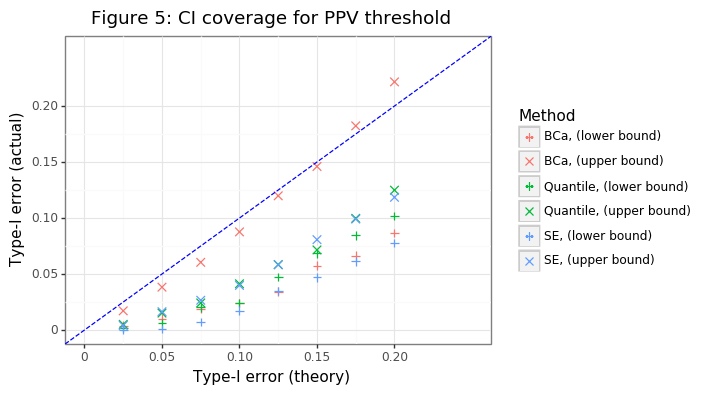

<ggplot: (8766715698169)>

In [15]:
res = pd.read_csv('res.csv')
# Get ground truth threshold for 50% PPV
thresh_ppv50 = minimize_scalar(fun=lambda x: (PPV_theory(x, mu0, mu1, prev)-target_ppv)**2).x
res = res.assign(ppv=lambda x: PPV_theory(x.value, mu0, mu1, prev))
res = res[res.value.notnull()].reset_index(None,True)
cn_gg = ['sim','alpha','method']
res2 = res.pivot_table('ppv',cn_gg,'tt').assign(lb=lambda x: x.lb > target_ppv, ub=lambda x: x.ub < target_ppv)
res2 = res2.reset_index().melt(cn_gg).rename(columns={'value':'viol'})
assert res.shape[0] == res2.shape[0]
res = res.merge(res2)
del res2
res_agg = res.groupby(['method','alpha','tt']).viol.apply(lambda x: pd.Series({'mu':x.mean(),'n':x.shape[0]})).reset_index()
res_agg = res_agg.pivot_table('viol',['method','alpha','tt'],'level_3').reset_index().assign(n=lambda x: x.n.astype(int))
res_agg = res_agg.assign(ci_u=lambda x: x.mu+norm.ppf(0.975)*np.sqrt(x.mu*(1-x.mu)/x.n),
                         ci_l=lambda x: x.mu-norm.ppf(0.975)*np.sqrt(x.mu*(1-x.mu)/x.n),
                         alpha2=lambda x: x.alpha/2)
di_method = {'bca':'BCa', 'quantile':'Quantile', 'se':'SE', 'arch':'ARCH-BCa'}
di_tt = {'lb':'lower bound', 'ub':'upper bound'}
res_agg = res_agg.assign(gg = lambda x: x.method.map(di_method)+', ('+x.tt.map(di_tt)+')')

colz = list(np.repeat(gg_color_hue(3),2))
shapez = list(np.tile(['+','x'],3))

plotnine.options.figure_size = (5.5,4)
xx = list(np.arange(0,0.25,0.05))
gg_inf = (ggplot(res_agg,aes(x='alpha2',y='mu',color='gg',shape='gg')) + theme_bw() + geom_point(size=3) + 
          scale_shape_manual(name='Method',values=shapez) + 
          scale_color_manual(name='Method',values=colz) + 
          geom_abline(intercept=0,slope=1,color='blue',linetype='--') + 
          labs(x='Type-I error (theory)',y='Type-I error (actual)') + 
          scale_x_continuous(limits=[0,0.25],breaks=xx) + 
          scale_y_continuous(limits=[0,0.25],breaks=xx) + 
          ggtitle('Figure 5: CI coverage for PPV threshold'))
gg_inf

Figure 5 shows that only the BCa approach gets anywhere near the right coverage for the upper bound, and the other approaches are much too conservative. Interestingly even the BCa approach has a lower bound interval which is conservative. This likely stems from the obvious finite-sample bias that comes from the empirical PPV curve.

In [16]:
# res_agg2 = res_agg.groupby(['method','alpha']).mu.sum().reset_index()
# res_agg2 = res_agg2.assign(gg = lambda x: x.method.map(di_method))
# plotnine.options.figure_size = (5.5,4)
# gg_inf = (ggplot(res_agg2,aes(x='alpha',y='mu',color='gg')) + theme_bw() + 
#           scale_color_discrete(name='Method') + geom_point(size=3) + 
#           geom_abline(intercept=0,slope=1,color='blue',linetype='--') + 
#           labs(x='Type-I error (theory)',y='Type-I error (actual)') + 
#           scale_x_continuous(limits=[0,0.25],breaks=xx) + 
#           scale_y_continuous(limits=[0,0.25],breaks=xx) + 
#           ggtitle('Simulation'))
# gg_inf

## (4) Compare to ARCH

To show that our functions developed in the post will obtain (nearly) identical results to using the `arch` package's BCa approach, we will turn off the stratified sampling and calculate the variance of a standard normal distribution. To comply with the `bootstrap` class, the `var_calc` function will have a built-in Jackknife estimator, which is can calculated efficiently since the determintic formula for the sample variance can be vectorized.

In [17]:
from arch.bootstrap import IIDBootstrap

def vfun(x):
    return x.var(ddof=1)

def var_calc(*args, **kwargs):
    """
    *args should be an IID draw
    """
    jackknife = False
    if 'jackknife' in kwargs:
        jackknife = kwargs['jackknife']
    # Calculate stat
    x = args[0]
    n = len(x)
    vv = x.var(ddof=1)
    if jackknife:  # Built in jackknife
        mu = x.mean()
        s2 = np.sum(x**2)
        mu = (mu - x/n)*(n/(n-1))
        s2 = s2 - x**2
        vv = (s2 - (n-1)*mu**2)/(n-2)
    return vv

np.random.seed(1234)
# nsim, nboot, n = 2000, 2000, 100
nsim, nboot, n = 2, 2000, 100
t1err = 0.1
alpha_seq = np.arange(0.05, 0.25, 0.05)
store = []
stime = time()
for ii in range(nsim):
    x = stats.norm(0,1).rvs(n)
    sim = bootstrap(nboot=nboot, func=var_calc)
    sim.fit(x)
    holder = []
    for alpha in alpha_seq:
        sim.get_ci(alpha=alpha,symmetric=True)
        holder.append(pd.DataFrame.from_dict(sim.di_ci).assign(tt=['lb','ub']).assign(alpha=alpha))
    holder = pd.concat(holder).assign(sim=ii)
    # Calculate with ARCH
    bs = IIDBootstrap(x)
    mat = np.zeros([len(alpha_seq), 2])
    for jj, alpha in enumerate(alpha_seq):
        ci_bca = bs.conf_int(func=vfun, reps=nboot, method='bca',size=1-alpha, tail='two').flatten()
        mat[jj] = ci_bca
    holder2 = pd.DataFrame(mat,columns=['lb','ub']).assign(alpha=alpha_seq,sim=ii)
    holder2 = holder2.melt(['alpha','sim'],None,'tt').rename(columns={'value':'arch'})
    holder3 = holder2.merge(holder,on=['alpha','sim','tt'])
    store.append(holder3)
    nleft, rate = nsim-(ii+1), (ii+1)/(time() - stime)
    if (ii+1) % 100 == 0:
        print('Simulation %i of %i' % (ii+1,nsim))
        print('ETA: %0.1f minutes' % (nleft/rate/60))
res_all = pd.concat(store).reset_index(None,True)
res_all = res_all.melt(['sim','alpha','tt'],None,'method').assign(viol=lambda x: np.where(x.tt=='lb',x.value>1,x.value<1))
#res_all.to_csv('res_all.csv', index=False)

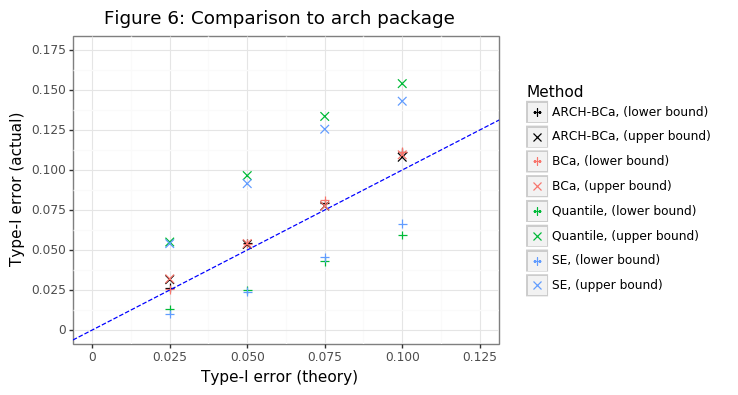

<ggplot: (8766715455761)>

In [19]:
res_all = pd.read_csv('res_all.csv')
res_all_agg = res_all.groupby(['method','alpha','tt']).viol.apply(lambda x: pd.Series({'mu':x.mean(),'n':x.shape[0]})).reset_index()
res_all_agg = res_all_agg.pivot_table('viol',['method','alpha','tt'],'level_3').reset_index().assign(n=lambda x: x.n.astype(int))
res_all_agg = res_all_agg.assign(gg = lambda x: x.method.map(di_method)+', ('+x.tt.map(di_tt)+')',
                                alpha2 = lambda x: x.alpha / 2)
colz = list(np.repeat(['black']+gg_color_hue(3),2))
shapez = list(np.tile(['+','x'],4))

plotnine.options.figure_size = (5.5,4)
yy = list(np.arange(0,0.1751,0.025))
xx = list(np.arange(0,0.1251,0.025))
gg_comp = (ggplot(res_all_agg,aes(x='alpha2',y='mu',color='gg',shape='gg')) + theme_bw() + geom_point(size=3) + 
          scale_shape_manual(name='Method',values=shapez) + 
          scale_color_manual(name='Method',values=colz) + 
          geom_abline(intercept=0,slope=1,color='blue',linetype='--') + 
          labs(x='Type-I error (theory)',y='Type-I error (actual)') + 
          scale_x_continuous(limits=[min(xx),max(xx)],breaks=xx) + 
          scale_y_continuous(limits=[min(yy),max(yy)],breaks=yy) + 
          ggtitle('Figure 6: Comparison to arch package'))
gg_comp

Figure 6 shows that the BCa approach yields (virtually) identical estimate to the one obtainable from the `arch` package. Since the estimate of the variance is skewed, it also shows the superiority of the BCa method over the simpler bootstrapping approaches since ther coverage for both lower and upper bounds is close to the expected level.

Most researchers that use the bootstrap to carry out inference on a statistic should probably be using the BCa approach. When the Jackknife estimator can be implemented effeciently, there is almost no additional computational overhead for using the BCa and it obtains an empirical coverage much closer to the expected level. Beyond sample means, most statistics show some form of skew or bias meaning the symmetric standard-error or quantile approach will be suboptimal. The BCa not only helps to remedy these problems, it gives researcher estimates that are much more efficient.